<a href="https://colab.research.google.com/github/Keganwealths/1stSuperstore/blob/main/Fine_tuning_Hugging_face_text_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [1]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install tensorflow
!pip install transformers[torch]
!pip install accelerate -U
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 50.1 MB/s eta 0:0

In [2]:
import os
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from transformers import Trainer, TrainingArguments
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gradio as gr

In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [6]:
# Load the dataset and display some values
df = pd.read_csv(r'/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/Train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [7]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [8]:
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [9]:
df.shape

(9999, 4)

In [10]:
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7999 entries, 9305 to 1387
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   7999 non-null   object 
 1   safe_text  7999 non-null   object 
 2   label      7999 non-null   float64
 3   agreement  7999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.5+ KB


In [12]:
duplicates = df.duplicated().sum()
duplicates


0

In [13]:
df.describe()

,label,agreement
count,9999.00000,9999.000000
mean,0.30153,0.854252
std,0.64674,0.180707
min,-1.00000,0.333333
25%,0.00000,0.666667
50%,0.00000,1.000000
75%,1.00000,1.000000
max,1.00000,1.000000


**Data Overview:**

What is the size of your dataset (number of samples)?
What is the distribution of sentiment labels (positive, negative, neutral, etc.)?
Are there any missing values in the text or sentiment labels?
**Text Data:**

What is the average length of the text data (e.g., number of words or characters)?
Are there any special characters, symbols, or emojis in the text that need special handling?
Is the text data in a consistent format, or does it require preprocessing (e.g., lowercasing, stemming, lemmatization)?
Are there any stop words that should be removed, or important domain-specific terms to be considered?
Class Distribution:

How balanced or imbalanced is the distribution of sentiment classes?
Is class imbalance an issue that needs to be addressed during model training?
Text Preprocessing:

Have you removed any irrelevant information, such as URLs or user handles in the text?
Have you cleaned the text data of any HTML tags, punctuation, or noise?
N-grams and Vocabulary:

What are the most common n-grams (e.g., unigrams, bigrams) in the text data?
Is there a need to limit the vocabulary size or apply feature selection methods to reduce dimensionality?
Word Clouds:

What are the most frequent words associated with each sentiment class?
Can you visualize these words using word clouds?
Text Length and Sentiment:

Is there a relationship between text length and sentiment (e.g., longer texts tend to be more negative or positive)?
Can you create histograms or box plots to visualize this?
**Time Trends:**

If applicable, is there a time component to your data?
Are there any trends in sentiment over time that may be relevant to your analysis?
Biases and Anomalies:

Are there any biases or anomalies in your data that might affect sentiment analysis (e.g., a specific source or user consistently posting positive or negative sentiment)?
Feature Engineering:

Can you extract additional features like sentiment scores from the text (e.g., sentiment lexicon-based features)?
Can you engineer features related to the length or structure of the text?


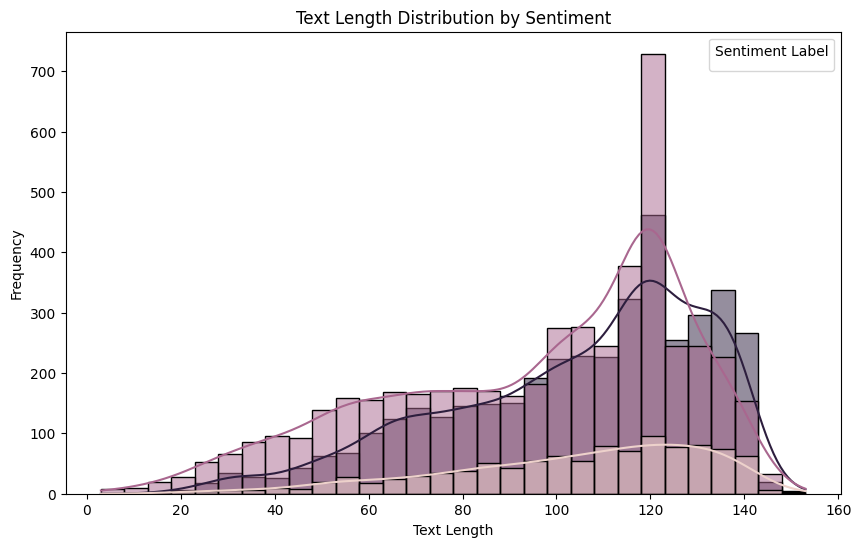

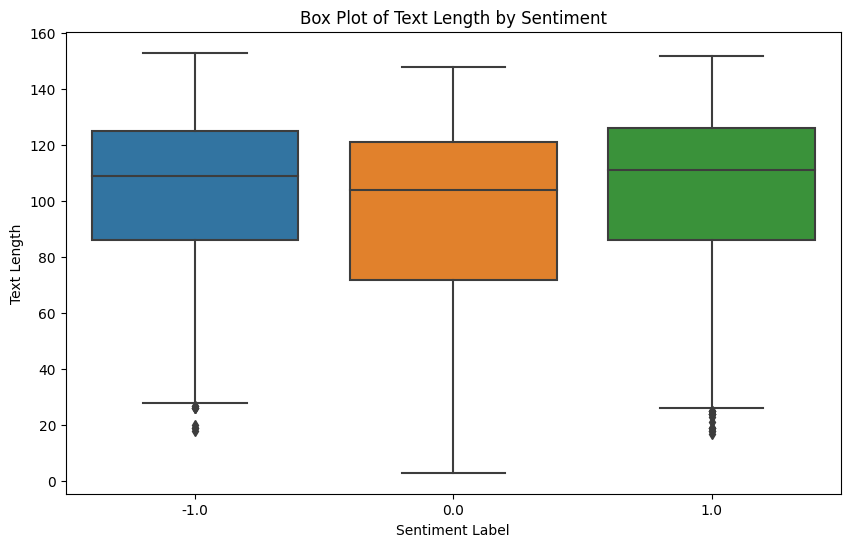

In [14]:
# Compute the length of each text and add it as a new column
df['text_length'] = df['safe_text'].apply(len)

# Create histograms to visualize text length distribution for different sentiment labels
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Sentiment Label')
plt.show()

# Create box plots to visualize text length for different sentiment labels
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='text_length')
plt.title('Box Plot of Text Length by Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Text Length')
plt.show()


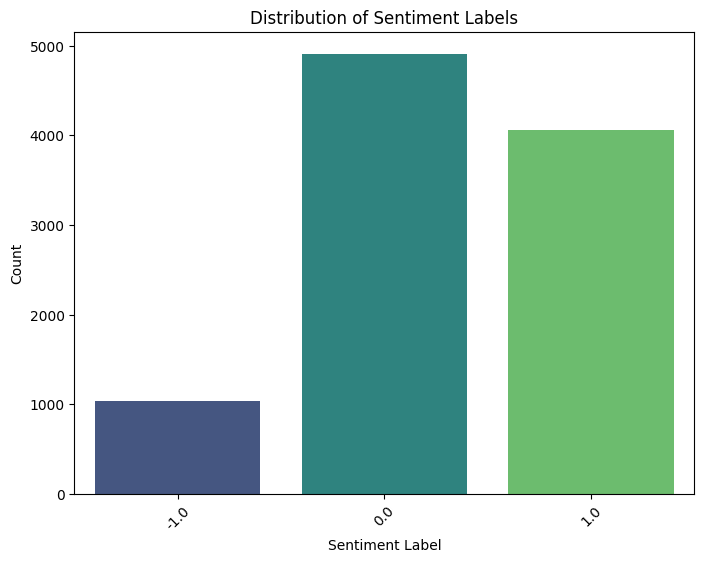

In [15]:
sentiment_counts = df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [16]:
#What is the average length of the text data
average_text_length = df['safe_text'].apply(len).mean()

print(f"The average length of the text data is {average_text_length:.2f} characters.")

The average length of the text data is 99.92 characters.


In [17]:
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user handles (Twitter handles, for example)
    text = re.sub(r'@[\w]+', '', text)

    # Remove punctuation and special characters
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text

# Apply the cleaning function to the 'safe_text' column
df['cleaned_text'] = df['safe_text'].apply(clean_text)


<ipython-input-17-ec1cac29ad00>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


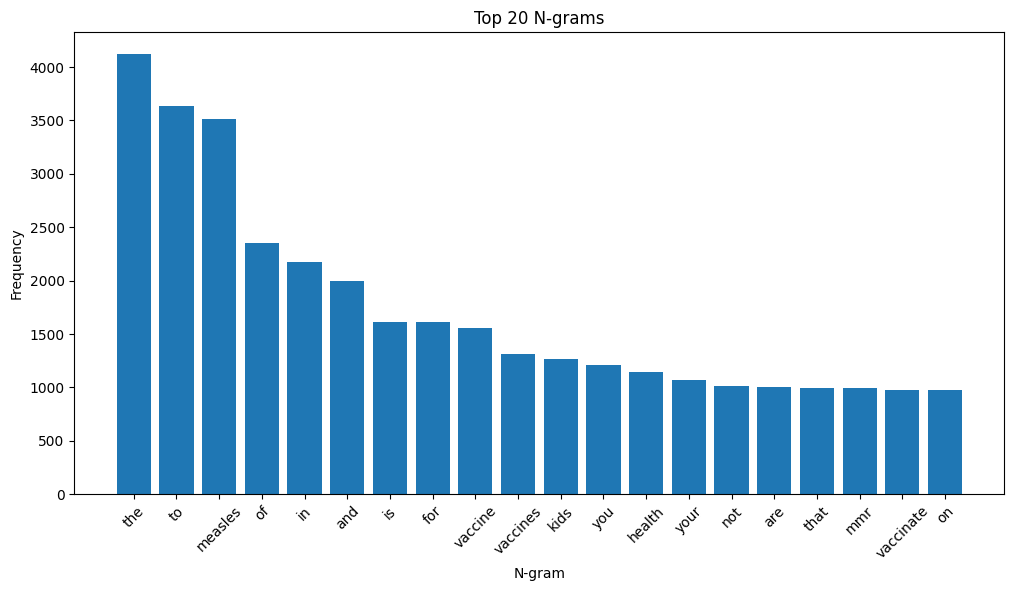

In [18]:

# Create a CountVectorizer to generate n-grams
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=100)

# Fit and transform the cleaned text to generate n-grams
ngrams = count_vectorizer.fit_transform(df['cleaned_text'])

# Get the vocabulary of n-grams
vocabulary = count_vectorizer.get_feature_names_out()

# Count the frequency of each n-gram
ngram_frequencies = ngrams.sum(axis=0)

# Create a DataFrame to analyze the vocabulary
ngram_df = pd.DataFrame({'Ngram': vocabulary, 'Frequency': ngram_frequencies.A1})

# Sort n-grams by frequency
ngram_df = ngram_df.sort_values(by='Frequency', ascending=False)

# Visualize the most frequent n-grams
plt.figure(figsize=(12, 6))
plt.bar(ngram_df['Ngram'][:20], ngram_df['Frequency'][:20])
plt.xticks(rotation=45)
plt.xlabel('N-gram')
plt.ylabel('Frequency')
plt.title('Top 20 N-grams')
plt.show()


In [19]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define a function to preprocess and tokenize text
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Create separate dataframes for positive and negative sentiment
positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == 0]

# Preprocess and tokenize the text for positive sentiment
positive_tokens = positive_df['safe_text'].apply(preprocess_text)

# Preprocess and tokenize the text for negative sentiment
negative_tokens = negative_df['safe_text'].apply(preprocess_text)

# Calculate word frequencies for positive sentiment
positive_word_freq = FreqDist([word for tokens in positive_tokens for word in tokens])

# Calculate word frequencies for negative sentiment
negative_word_freq = FreqDist([word for tokens in negative_tokens for word in tokens])

# Get the most common words for positive sentiment
most_common_positive_words = positive_word_freq.most_common(10)

# Get the most common words for negative sentiment
most_common_negative_words = negative_word_freq.most_common(10)

print("Most common words for positive sentiment:")
print(most_common_positive_words)

print("Most common words for negative sentiment:")
print(most_common_negative_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Most common words for positive sentiment:
[('user', 2125), ('url', 1691), ('measles', 949), ('kids', 925), ('vaccinate', 789), ('vaccines', 726), ('vaccine', 689), ('children', 567), ('get', 494), ('dont', 431)]
Most common words for negative sentiment:
[('user', 2569), ('url', 2495), ('measles', 2429), ('mmr', 767), ('health', 683), ('vaccine', 566), ('immunity', 506), ('outbreak', 380), ('“', 359), ('cases', 317)]


In [20]:
# Save splitted subsets
train.to_csv("/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/eval_subset.csv", index=False)

In [21]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [22]:
dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [23]:
# Load the training and evaluation data
train_data = pd.read_csv(r"/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/train_subset.csv")
eval_data = pd.read_csv(r"/content/drive/MyDrive/Career_Accelerator_P5-NLP-master/Career_Accelerator_P5-NLP-master/zindi_challenge/data/eval_subset.csv")

In [24]:
eval_data

,tweet_id,safe_text,label,agreement
0,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.000000
2,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
3,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000
...,...,...,...,...
1995,J7IQVE6X,<user> Is Imus really telling people to chill ...,0.0,0.666667
1996,ICX9AF8Y,"After overseas trip, Wake resident could have ...",0.0,1.000000
1997,C9TSI9HK,How many kids at a school aren't immunized? Pl...,0.0,1.000000
1998,ZR5J41GP,Come &amp; Celebrate <user> #goodtime #mmr #dc...,0.0,0.666667


In [25]:
# Number of classes for ternary classification
num_classes = 3

# Ensure labels are in the correct format (0, 1, or 2)
train_labels = train_data["label"].map(lambda x: x + 1)  # Map -1 to 0, 0 to 1, and 1 to 2
eval_labels = eval_data["label"].map(lambda x: x + 1)

# Ensure labels are in the correct format (0 or 1)
train_labels = train_data["label"].tolist()
eval_labels = eval_data["label"].tolist()

# Ensure that the column names in your CSV files match the code
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Convert the "safe_text" column to a list of strings
train_texts = train_data["safe_text"].tolist()
eval_texts = eval_data["safe_text"].tolist()


In [26]:
print("Unique Labels in Train Data:", set(train_labels))
print("Unique Labels in Eval Data:", set(eval_labels))


Unique Labels in Train Data: {0.0, 1.0, -1.0}
Unique Labels in Eval Data: {0.0, 1.0, -1.0}


In [27]:
#convert to a numpy
import numpy as np
unique_train_labels = np.unique(train_labels)
unique_eval_labels = np.unique(eval_labels)

print("Unique Labels in Train Data:", unique_train_labels)
print("Unique Labels in Eval Data:", unique_eval_labels)

Unique Labels in Train Data: [-1.  0.  1.]
Unique Labels in Eval Data: [-1.  0.  1.]


In [28]:
train_labels = (np.array(train_labels) > 0).astype(int)
eval_labels = (np.array(eval_labels) > 0).astype(int)

In [29]:
# Tokenize the list of strings
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
eval_encodings = tokenizer(eval_texts, padding=True, truncation=True, return_tensors="pt")


In [30]:
# Create PyTorch datasets
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Initialize the datasets
train_dataset = TextDataset(train_encodings, train_labels)
eval_dataset = TextDataset(eval_encodings, eval_labels)


In [31]:
# Encode labels into numerical values
label_encoder = LabelEncoder()
train_data["label_encoded"] = label_encoder.fit_transform(train_data["label"])

# Split your dataset into training and evaluation sets
train_data, eval_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Ensure you have one-hot encoded labels
train_labels = pd.get_dummies(train_data["label_encoded"]).values
eval_labels = pd.get_dummies(eval_data["label_encoded"]).values

# Initialize the model for multi-class classification with three classes
num_classes = 3
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Set up TrainingArguments
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=16,  # Reduce the batch size
    per_device_eval_batch_size=32,   # Reduce the batch size
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    num_train_epochs=3,
    report_to="tensorboard",
    logging_dir="./logs",
    logging_steps=100,
    gradient_accumulation_steps=4,  # Use gradient accumulation to simulate larger batches
    dataloader_drop_last=True,  # Drop the last batch if it's smaller
)

In [33]:
# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)


In [34]:
# Choose the first column as the class labels
train_labels = train_labels[:, 0]
eval_labels = eval_labels[:, 0]


In [35]:
# Finally, train the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=372, training_loss=0.37572821750435775, metrics={'train_runtime': 513.8851, 'train_samples_per_second': 46.697, 'train_steps_per_second': 0.724, 'total_flos': 1590520610165760.0, 'train_loss': 0.37572821750435775, 'epoch': 2.98})

In [43]:
!pip install -q gradio --upgrade


In [48]:
# Sentiment analysis function using the trained model
def sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Move input tensor to the same device as the model
    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Get the probability distribution over the classes
    probabilities = torch.softmax(outputs.logits, dim=1)
    confidence_percentage = probabilities[0, predicted_class].item() * 100

    # Map the predicted class index to a human-readable label
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    sentiment = sentiment_labels[predicted_class]
    return sentiment, confidence_percentage

# Gradio interface setup
demo = gr.Interface(
    fn=sentiment_analysis,
    inputs=gr.Textbox(placeholder="Write your tweet here..."),
    outputs=[gr.Label("Sentiment Analysis Result"), gr.Label("Confidence Percentage")],
    examples=[["This is wonderful!"]],
    theme="compact",
    title="Twitter Sentiment Analysis"
)

# Launch the Gradio interface with debugging enabled
demo.launch(share=True, debug=True)


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:490: UserWarning: Cannot load compact. Caught Exception: The space compact does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d16f789a35f3095904.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://d16f789a35f3095904.gradio.live


In [37]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define your evaluation function
def compute_metrics(p):
    # p is a named tuple with predictions and labels
    predictions, labels = p.predictions, p.label_ids
    # Apply the appropriate threshold to predictions if needed
    # threshold = 0.5
    # predicted_labels = (predictions[:, 1] > threshold).astype(int)

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(labels, predictions.argmax(-1))
    # You can add other metrics like precision, recall, F1-score here

    return {"accuracy": accuracy}


In [38]:
# Define the TrainingArguments for evaluation
training_args = TrainingArguments(
    output_dir="./output",  # Use the output directory of the trained model
    per_device_eval_batch_size=32,
    report_to="tensorboard",
)

# Set up the Trainer for evaluation
trainer = Trainer(
    model=model,  # Your trained model
    args=training_args,
    compute_metrics=compute_metrics,  # Use the evaluation function
    tokenizer=tokenizer,  # Your tokenizer
)

In [39]:
# Evaluate the model on your evaluation dataset
results = trainer.evaluate(eval_dataset)

# Print and display the evaluation results
print("***** Evaluation results *****")
for key, value in results.items():
    print(f"{key}: {value}")


***** Evaluation results *****
eval_loss: 0.44779354333877563
eval_accuracy: 0.824
eval_runtime: 8.4671
eval_samples_per_second: 236.209
eval_steps_per_second: 7.441


Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.